# Procesamiento de Lenguaje Natural - **Trabajo Práctico 2**
# **Detectando rumores en los medios sociales**

Detectar aquellos tweets que contienen información que todavía no ha sido verificada (los rumores), distinguiéndola de lo que no son rumores!



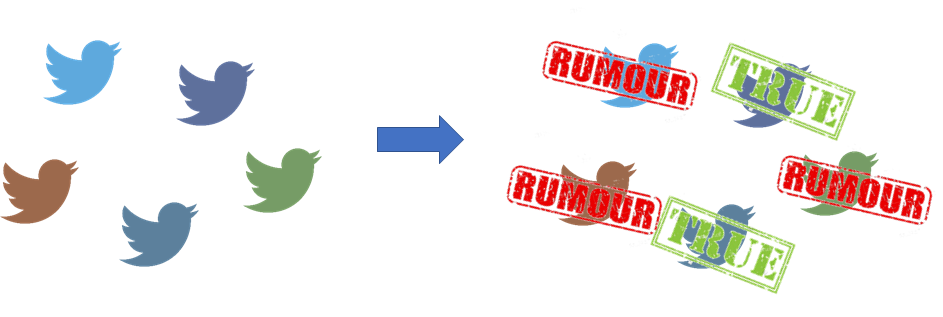

### Qué tienen que hacer?


1.    Pre-procesamiento. Selección de features léxicas.
**2.    Features sintácticas & Pipeline.**
3.    Modelo de clasificación.

Del práctico anterior deben haber:

* Procesado los json con los tweets y almacenarlos en alguna estructura.
* Decidido si considerar o no las reacciones.
* Elegido algunas características para representar los tweets.
* Aplicado pasos de pre-procesamiento sobre el texto.
* Pensado en alguna estrategia para representar los tweets (opcional).
* Calculado estadísticas sobre los tweets (por ejemplo, palabras más frecuentes)

Ahora, para este práctico:

* De todos los análisis que vimos hasta ahora, elegir al menos dos características nuevas para incorporar a los tweets.
  * Por ejemplo, agregar el sentimiento de los tweets, la emoción o elegir solo utilizar un tipo de etiqueta POS.
  * La selección de estas características debe quedar integrada con el procesamiento que hicieron en el TP 1.
* Definir la representación de los tweets a utilizar.
  * Recordar que el objetivo final es entrenar un modelo de clasificación, con lo que la representación tiene que ser “amigable” con el posterior proceso de entrenamiento y test.
* Integración del procesamiento completo. 
  * Desde la carga del dataset hasta la creación de la representación.

**Nota**. Depende de cómo decidan realizar la solución, puede que algunos de los bloques de código definidos no los utilicen. En ese caso, pueden borrarlos.

**Nota 2**. Los embeddings que vimos pueden ser utilizados como características adicionales o como la representación de los tweets.


## Carga del dataset

El código que hayan utilizado en el práctico anterior para la obtención de los datos y crear la primera representación de los tweets. Recordar que la notebook debe poder ejecutarse sin errores.

In [ ]:
import sys
import time
import requests
import urllib.request
import os
import json
import pandas as pd
import gzip
import shutil
from zipfile import ZipFile
from datetime import datetime

In [ ]:
!git clone https://github.com/LuchoTangorra/DUIA-NLP.git
!git pull

fatal: destination path 'DUIA-NLP' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
#url = "https://drive.google.com/uc?export=download&id=13POHlYNlEVJuMAXkXVNJQvjkRjAye8tL"
datapath = r"/content/DUIA-NLP/sydneysiege-opcion3.zip"

In [ ]:
print("Extracting data...")
with ZipFile(datapath, 'r') as zipObj:
    zipObj.extractall('.')

Extracting data...


In [ ]:
def json_to_df(json_path):
  with open(json_path) as json_file:
    jarray = json.load(json_file)

  df_aux = list()
  for item in jarray:
      df_aux.append(item)

  jsondf = pd.DataFrame(df_aux)
  jsondf = jsondf.set_index('id') # seteamos el id como index del frame
  return jsondf

filepath = "sydneysiege-opcion3/tweets.json"
df = json_to_df(filepath).reset_index(drop=False)
df = df.set_index('id')

In [ ]:
df

,contributors,truncated,text,in_reply_to_status_id,favorite_count,source,retweeted,coordinates,entities,in_reply_to_screen_name,id_str,retweet_count,in_reply_to_user_id,favorited,user,geo,in_reply_to_user_id_str,lang,created_at,in_reply_to_status_id_str,place,rumour,possibly_sensitive,extended_entities,filter_level
id,,,,,,,,,,,,,,,,,,,,,,,,,
544267656597995521,None,False,BREAKING: Hostages are being forced to hold an...,None,54,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544267656597995521,445,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:08:15 +0000 2014,None,None,yes,NaN,NaN,NaN
544268186292867072,None,False,BREAKING: Gunman takes hostages in cafe in Mar...,None,12,"<a href=""https://about.twitter.com/products/tw...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544268186292867072,149,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:10:22 +0000 2014,None,None,yes,False,NaN,NaN
544268637134393344,None,False,UPDATE: An ISIS flag is being displayed in the...,None,39,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544268637134393344,202,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:12:09 +0000 2014,None,None,yes,NaN,NaN,NaN
544268732046913536,None,False,#BREAKING: Hostages are being held and a siege...,None,9,"<a href=""http://www.skynews.com.au"" rel=""nofol...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544268732046913536,108,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:12:32 +0000 2014,None,None,yes,NaN,NaN,NaN
544269221564137472,None,False,BREAKING: A Sydney cafe at Martin Place is bei...,None,84,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,"{'symbols': [], 'user_mentions': [], 'hashtags...",None,544269221564137472,665,NaN,False,"{'follow_request_sent': False, 'profile_use_ba...",None,None,en,Sun Dec 14 23:14:29 +0000 2014,None,None,yes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544521260840267776,None,False,Sydney siege ends as police storm Lindt Cafe a...,None,18,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,"{'user_mentions': [], 'symbols': [], 'trends':...",None,544521260840267776,100,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:55:59 +0000 2014,None,None,no,False,NaN,low
544521433473634304,None,False,"Breaking News: #SydneySiege is over, according...",None,315,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,"{'symbols': [], 'media': [{'expanded_url': 'ht...",None,544521433473634304,489,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:56:41 +0000 2014,None,None,no,False,{'media': [{'expanded_url': 'http://twitter.co...,low
544521788777304064,None,False,Watch gunfire erupt and hostages flee chocolat...,None,91,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,"{'symbols': [], 'media': [{'expanded_url': 'ht...",None,544521788777304064,181,NaN,False,"{'follow_request_sent': None, 'profile_use_bac...",None,None,en,Mon Dec 15 15:58:05 +0000 2014,None,None,no,False,{'media': [{'expanded_url': 'http://twitter.co...,low


#### Se optó por mantener las siguiente features: 
- text: el texto que tenemos que ver si es info falsa o no.
- favorite_count: mide la cantidad de favoritos que tuvo el texto. Puede ser el caso de que los textos de info real tengan mas favoritos, hay que chequear.
- retweet_count: simil anterior.
- possibly_sensitive: quizas los rumos son mas morbosos, tambien hay que ver si este atributo nos es de utilidad. Hay varios NaN, los cuales tenemos uqe tomar en cuenta.
- rumour: clase objetivo.

## Análisis faltante del TP1

A continuación se analiza el efecto de eliminar caracteres repetidos.

In [ ]:
!pip install contractions
!pip install unidecode

import contractions
import re
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode

     |████████████████████████████████| 245kB 3.5MB/s 
     |████████████████████████████████| 317kB 7.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=f41d05196b9b2cb56bd21c7824b949c72b9566a0754125627fec587196e78bfb
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
def remove_repeated_characters(text_list):
  '''
  Se eliminan TODOS los caracteres repetidos
  '''
  def remove_rep_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)
  return [remove_rep_chars(w) for w in text_list]

def words_dict(text):
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(text)
  return set(vectorizer.get_feature_names())

In [ ]:
df_prepro = df['text'].copy()
df_prepro = df_prepro.apply(lambda x: [contractions.fix(word) for word in x.split()])
df_prepro = df_prepro.apply(lambda x: remove_repeated_characters(x))
df_prepro = df_prepro.apply(lambda x: ' '.join(x))

#Comparacion entre los datos pre procesados y no pre procesados.
print('With prepro:           ', len(words_dict(df_prepro)))
print('Without prepro:        ', len(words_dict(df['text'])))
print('Difference in corpus:  ', len(words_dict(df['text'])) - len(words_dict(df_prepro)))
print('Different words (len): ', len(words_dict(df['text']) - words_dict(df_prepro)))
print('Different words:       ', words_dict(df['text']) - words_dict(df_prepro))

With prepro:            3490
Without prepro:         3535
Difference in corpus:   45
Different words (len):  578
Different words:        {'aussie', 'hxz8effn3f', 'unravelling', 'c_good', 'horrific', 'community', 'appreciated', 'issued', 'i1psupekkb', 'understood', '1nlr4eqqbn', 'hellbent', 'off', 'really', 'buzzfeedoz', 'immediate', 'terrifying', 'messenger', 'keep', '9999', 'ggugp4kv9c', 'appears', 'bbcworld', 'affected', 'committee', 'soccer', 'matter', 'qhpppa6g33', 'wouldn', 'illness', 'witness', 'attacks', 'passengers', 'hillary', 'greens', 'planning', 'bdutt', 'bigger', 'yyxzgavclp', 'committed', 'zeeginganinja', 'fbdzwwongg', 'three', 'liztilley84', 'sukkymk08y', 'tweeting', 'looks', 'll', 'http', 'assault', 'innocents', 'ozzie', 'collective', 'speedy', '100m', 'flees', 'calmness', 'llznucazg5', 'tweeted', 'eyewitnesses', 'need', 'basically', 'cause', 'pisses', 'wrapped', 'ppogjw4ynx', 'suggest', 'refugee', 'follower', 'still', 'wclvv7coul', 'surreal', 'vanoo5rndd', 'getty', 'co

Vemos que en total hay 45 palabras que se "desaparecen" (son iguales a la misma palabra pero sin caracteres repetidos) y en total 578 palabras cambian como se escriben. Vemos que un de las palabras que nos podria generar problemas es "too", la cual pasa a ser "to". 

Al haber tan poco cambio entre el texto procesado y el sin procesar se opta por evitarlo, ya que nos puede resultar en palabras que no existen (y vamos a realizar lemmatization, por lo que no tiene sentido eliminar las palabras que existen).

A continuación se analiza el efecto de eliminar las tildes.

In [ ]:
df_text = df['text'].copy()
df_text = df_text.apply(lambda x: unidecode(x))

df_prepro = df['text'].copy()
df_prepro = df_prepro.apply(lambda x: unidecode(x))

#Comparacion entre los datos pre procesados y no pre procesados.
print('With prepro:           ', len(words_dict(df_prepro)))
print('Without prepro:        ', len(words_dict(df['text'])))
print('Difference in corpus:  ', len(words_dict(df['text'])) - len(words_dict(df_prepro)))
print('Different words (len): ', len(words_dict(df['text']) - words_dict(df_prepro)))
print('Different words:       ', words_dict(df['text']) - words_dict(df_prepro))

With prepro:            3534
Without prepro:         3535
Difference in corpus:   1
Different words (len):  2
Different words:        {'café', 'cafés'}


In [ ]:
#Ahora chequeamos si cafe existe sin  tilde
print('cafe' in words_dict(df['text']))
print('cafes' in words_dict(df['text']))

True
False


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text, is_list=False):
    if is_list:
      text = ' '.join(text)
    
    doc = nlp(text)
    lemmatized = ''
    for word in doc:
      if not word.lemma_.startswith('-') :
          lemmatized += word.lemma_ + ' '
    
    return lemmatized

In [ ]:
print(lemmatize_text('cafe'))
print(lemmatize_text('café'))
print(lemmatize_text('cafes'))
print(lemmatize_text('cafés'))

cafe 
café 
cafe 
cafés 


Vemos que las unicas palabras que tienen tildes y nos generan una palabra más al corpus es café y cafés. Esto puede no disminuir mucho el tamaño del corpus pero vimos que la palabra parece ser importante para diferenciar, por lo que mantener una sola palabra para representar cafe parece ser útil. 

Vemos que el lemmatizer tambien elimina el plural de la palabra sin tilde, por lo que al eliminar el tilde antes de hacer lemma nos aseguramos que queda la misma palabra (cafe).

## Agregado de nuevas características

*De todos los análisis que vimos hasta ahora, elegir al menos dos características nuevas para incorporar a los tweets. Explicar brevemente por qué las eligieron. Integrar la selección al código que tenían en el práctico anterior.*

In [ ]:
!pip install unidecode
!pip install contractions
!pip install spacy

import re
import contractions
import nltk
import spacy
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from unidecode import unidecode
from IPython.display import clear_output
from collections import Counter
import string
from nltk.data import load

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
#Definición de funciones y variables útiles
def remove_websites(text, startWith='http'):
  '''
  Se remueven los sitios web de los tweets (iniciando con http y www).
  '''
  try:
    out = text
    while (True):
      http_index = out.index(startWith)
      try:
        end_http_index = out[http_index:].index(" ") + http_index
      except:
        end_http_index = len(out)
      out = out[:http_index] + out[end_http_index:]
  except:
    return out

def remove_special_characters(text):
  '''
  Se mantienen solo las letras en el texto.
  '''
  pattern = r'[^a-z\s]'
  text = re.sub(pattern, '', text)
  return text

def remove_stopwords(text):
  '''
  Se eliminan los stopwords (nltk+agregados)
  '''
  text_no_stopwords = [w for w in text.split() if not w in nltk_stopwords]
  return ' '.join(text_no_stopwords)

def remove_accent_mark(text, words=None):
  ''' 
  Se eliminan las tildes de las palabras elegidas
  '''
  out = []
  if words is None:
    return
  for w in text.split():
    if w in words:
      out.append(unidecode(w))
    else:
      out.append(w)
  return ' '.join(out)

#Feature agregada
def sentiment_value(text, is_list=False):
  ''' 
  Usamos NLTK vader ya que se dice que es mejor para texto
  de redes sociales. Obtenemos solamente el compound.
  '''
  if is_list:
    text = ' '.join(text)
  polarity_score = sid.polarity_scores(text)
  return polarity_score['compound']

#Feature agregada
def pos_counter(df, is_list=True):
  '''
  Creo las nuevas features (pueden ser varias) y les asigno los
  valores correspondientes segun el texto.
  '''
  out = df.copy()

  tagdict = load('help/tagsets/upenn_tagset.pickle')
  pos_labels = list(tagdict.keys())
  pos_labels.append('#')  

  if is_list:
    out['text'].apply(lambda x: ' '.join(x))
    
  for label in pos_labels:
    out[label] = 0

  def set_pos_labels_count(row):
    '''
    Cuento los valores de cada pos encontrado y los pongo
    en el dataframe.
    '''
    def get_pos_tags(text):
      pos_tags = []
      for word in nltk.word_tokenize(text):
        pos = nltk.pos_tag([word])[0][1]
        pos_tags.append(pos)
      return pos_tags

    count_labels = Counter(get_pos_tags(row['text']))
    for key in count_labels.keys():
      row[key] = count_labels[key]
    return row

  out = out.apply(lambda x: set_pos_labels_count(x), axis=1)
  
  return out

#Feature modificada, anteriormente era stemming
def lemmatize_text(text, is_list=False):
  '''
  Internamente spaCy usa etiquetado POS. Otra opción 
  es utilizar NLTK y hacer a mano el etiquetado POS (con 
  alguna libreria).

  Anteriormente se realizo stemming pero con lo que se aprendió
  de lemmatización se optó por esta opción.
  '''
  if is_list:
    text = ' '.join(text)
  
  doc = nlp(text)
  lemmatized = ''
  for word in doc:
    if not word.lemma_.startswith('-') :
        lemmatized += word.lemma_ + ' '
  
  return lemmatized

nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.extend(["co","http","sydneysiege","sydney","hostages","police","hostage","people", 'breaking'])
sid = SentimentIntensityAnalyzer()

nlp = spacy.load("en_core_web_sm")

## Pipeline de preprocesamiento

In [ ]:
def pre_processing_pipeline(df, lemmatize=True, delete_stopwords=True):
  out = df.copy()

  start = time.time()
  out = out[['text', 'user', 'created_at', 'favorite_count', 'retweet_count', 'rumour']]
  
  #Nos quedamos solo con el verified del usuario y con la cantidad de seguidores que tenga la acc.
  out['user_verified'] = out['user'].apply(lambda x: x['verified'])
  out['user_followers'] = out['user'].apply(lambda x: x['followers_count'])
  out.drop('user', axis=1, inplace=True)
  
  #Del created_at nos quedamos unicamente con la hora en el que se realizó el tweet
  out['created_at'] = out['created_at'].apply(lambda x: datetime.strptime(x[:-11], '%a %b %d %H:%M:%S').time().hour)
  end = time.time()
  print("Time selecting features: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_websites(x))
  out['text'] = out['text'].apply(lambda x: remove_websites(x, startWith='www'))
  end = time.time()
  print("Time removing websites: ", end - start)
  
  #Feature agregada
  start = time.time()
  out = pos_counter(out)
  end = time.time()
  print("Time counting POS labels: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: x.lower())
  end = time.time()
  print("Time setting to lowercase: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
  out['text'] = out['text'].apply(lambda x: ' '.join(x))
  end = time.time()
  print("Time fixing contractions: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_special_characters(x))
  end = time.time()
  print("Time removing special characters: ", end - start)

  #Eliminamos las tildes en café y cafés.
  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_accent_mark(x, ['café', 'cafés']))
  end = time.time()
  print("Time removing accent marks in café and cafés: ", end - start)

  #Se elimino el spell check ya que demora mucho tiempo.

  #Feature agregada
  start = time.time()
  out['word_count'] = out['text'].apply(lambda x: len(x))
  end = time.time()
  print("Time counting words: ", end - start)

  if delete_stopwords:
    start = time.time()
    out['text'] = out['text'].apply(lambda x: remove_stopwords(x))
    end = time.time()
    print("Time removing stopwords: ", end - start)

  #Feature agregada
  start = time.time()
  out['sentiment'] = out['text'].apply(lambda x: sentiment_value(x, is_list=True))
  end = time.time()
  print("Time analizing sentiment: ", end - start)

  #Feature modificada, anteriormente era stemming
  if lemmatize:
    start = time.time()
    out['text'] = out['text'].apply(lambda x: lemmatize_text(x))
    end = time.time()
    print("Time lemmatizing: ", end - start)

  return out

In [ ]:
df_preprocessed = pre_processing_pipeline(df)

Time selecting features:  0.027330875396728516
Time removing websites:  0.0046541690826416016
Time counting POS labels:  3.3694353103637695
Time setting to lowercase:  0.0013217926025390625
Time fixing contractions:  0.05150461196899414
Time removing special characters:  0.004193544387817383
Time removing accent marks in café and cafés:  0.005197286605834961
Time counting words:  0.001699686050415039
Time removing stopwords:  0.04299449920654297
Time analizing sentiment:  0.023880720138549805
Time lemmatizing:  10.764492273330688


El lemmatizer tarda mucho a comparacion (10 segundos aprox), por lo que según el caso en el que se desee implementar hay que ver si usar ese o stemming, el cual es mas rapido. Para el ejercicio actual, como no importa tanto el tiempo que demore, se mantiene el lemmatizer

In [ ]:
#Muestra de df pre procesado...
df_preprocessed.iloc[0:5]

,text,created_at,favorite_count,retweet_count,rumour,user_verified,user_followers,LS,TO,VBN,'',WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,MD,VB,WRB,NNP,EX,NNS,SYM,CC,CD,POS,#,word_count,sentiment
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
544267656597995521,force hold isis flag lindt cafe sydneys martin...,23,54,445,yes,True,1672,0,1,1,0,0,0,1,0,0,0,1,10,3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,3,0,0,1,1,1,132,0.0
544268186292867072,gunman take cafe martin place,23,12,149,yes,True,2114,0,0,0,0,0,0,0,0,1,0,0,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,61,0.0
544268637134393344,update isis flag display window caf siege sydn...,23,39,202,yes,True,26903,0,0,0,0,0,0,1,0,1,0,0,12,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,102,0.0
544268732046913536,hold siege take place sydney lindt chocolat ca...,23,9,108,yes,True,150994,0,0,0,0,0,0,2,0,1,0,1,10,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,107,0.0
544269221564137472,cafe martin place hold inside hand windows isi...,23,84,665,yes,True,1672,0,0,0,0,0,0,1,0,1,0,0,9,2,0,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,1,131,0.0


## Agregado de nuevas features

#### Sentiment analysis

El siguiente análisis lo hice y luego lo plasme en el pre procesamiento, por lo que los valores ya se encuentran en el df anterior. Esto lo plantee de este modo para mantener la estructura del colab propuesto.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sid = SentimentIntensityAnalyzer()

def sentiment_analysis_neu(text):
  polarity_score = sid.polarity_scores(text)
  return polarity_score['neu']

def sentiment_analysis_neg(text):
  polarity_score = sid.polarity_scores(text)
  return polarity_score['neg']

def sentiment_analysis_pos(text):
  polarity_score = sid.polarity_scores(text)
  return polarity_score['pos']

def sentiment_analysis_comp(text):
  polarity_score = sid.polarity_scores(text)
  return polarity_score['compound']

def sentiment_analysis(text):
  polarity_score = sid.polarity_scores(text)
  return polarity_score
  
def plot_hist_by_rumour(df, by='compound', bins=20):
  plt.hist(df.loc[compound['rumour'] == 'yes', by], bins=bins, alpha=0.5)
  plt.hist(df.loc[compound['rumour'] == 'no', by], bins=bins, alpha=0.5)
  plt.legend(['rumour', 'no rumour'])
  plt.show()

threshold = 0.3
def print_max_min_mean(df, is_compound=False):
  print('Max value:     ', df.max())
  print('Min value:     ', df.min())
  print('Mean value:    ', df.mean())
  print('Std value:     ', df.std())
  if not is_compound:
    print('Count items:   ', df.where(lambda x: x > threshold).count())

In [ ]:
#Para chequear se aplica todo el prepro menos el lemmatizer
test = pre_processing_pipeline(df, lemmatize=False)
test['text'] = test['text'].apply(lambda x: ' '.join(x))
clear_output()
print(test['text'])
test['text'].apply(lambda x: sentiment_analysis(x))

id
544267656597995521    f o r c e d   h o l d   i s i s   f l a g   l ...
544268186292867072    g u n m a n   t a k e s   c a f e   m a r t i ...
544268637134393344    u p d a t e   i s i s   f l a g   d i s p l a ...
544268732046913536    h e l d   s i e g e   t a k i n g   p l a c e ...
544269221564137472    c a f e   m a r t i n   p l a c e   h e l d   ...
                                            ...                        
544521260840267776    s i e g e   e n d s   s t o r m   l i n d t   ...
544521433473634304                          n e w s   a c c o r d i n g
544521788777304064    w a t c h   g u n f i r e   e r u p t   f l e ...
544521880661950464    a u t h o r i t i e s   c o n f i r m e d   s ...
544521948924248066    w a t c h   d r a m a t i c   m o m e n t   t ...
Name: text, Length: 1221, dtype: object


id
544267656597995521    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544268186292867072    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544268637134393344    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544268732046913536    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544269221564137472    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
                                            ...                        
544521260840267776    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544521433473634304    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544521788777304064    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544521880661950464    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
544521948924248066    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
Name: text, Length: 1221, dtype: object

Vemos que son todos similares, por lo que vamos a hacer un analisis mas detallado para ver si nos podria servir o no.

In [ ]:
print('TOTAL DF LENGTH:', len(df))

print("\n-------Neutral:")
print_max_min_mean(test['text'].apply(lambda x: sentiment_analysis_neu(x)))
print("\n-------Positive:")
print_max_min_mean(test['text'].apply(lambda x: sentiment_analysis_pos(x)))
print("\n-------Negative:")
print_max_min_mean(test['text'].apply(lambda x: sentiment_analysis_neg(x)))
print("\n-------Compound:")
compound = test.copy()
compound['compound'] = test['text'].apply(lambda x: sentiment_analysis_comp(x))
print_max_min_mean(compound['compound'], is_compound=True)

TOTAL DF LENGTH: 1221

-------Neutral:
Max value:      0.0
Min value:      0.0
Mean value:     0.0
Std value:      0.0
Count items:    0

-------Positive:
Max value:      0.0
Min value:      0.0
Mean value:     0.0
Std value:      0.0
Count items:    0

-------Negative:
Max value:      0.0
Min value:      0.0
Mean value:     0.0
Std value:      0.0
Count items:    0

-------Compound:
Max value:      0.0
Min value:      0.0
Mean value:     0.0
Std value:      0.0


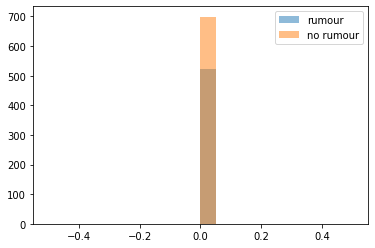

In [ ]:
plot_hist_by_rumour(compound)

Vemos que hay muchos neutrales pero tambien hay varios que son positivos y negativos. A pesar de esto poseen un valor de compound muy cercano al 0, por lo que el "promedio" calculado para los tres estados nos lleva a que suele ser neutro el sentimiento.

###Para asegurarme pruebo TextBlob

In [ ]:
from textblob import TextBlob

In [ ]:
df_text_blob = test.copy()
df_text_blob['compound'] = df_text_blob['text'].apply(lambda x: TextBlob(x).polarity)
print("Total tweets:     ", len(df_text_blob))
print("Neutral tweets:   ", df_text_blob['compound'].where(lambda x: x == 0.0).count())
print("Positive tweets:  ", df_text_blob['compound'].where(lambda x: x > threshold).count())
print("Negative tweets:  ", df_text_blob['compound'].where(lambda x: x < -threshold).count())
print("Max positive:     ", df_text_blob['compound'].max())
print("Max negative:     ", df_text_blob['compound'].min())
print("Mean value:       ", df_text_blob['compound'].mean())

Total tweets:      1221
Neutral tweets:    1221
Positive tweets:   0
Negative tweets:   0
Max positive:      0.0
Max negative:      0.0
Mean value:        0.0


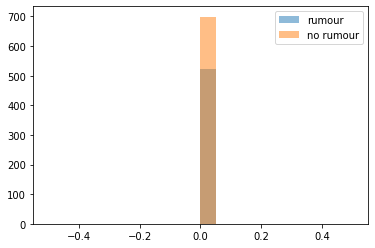

In [ ]:
plot_hist_by_rumour(df_text_blob)

Ambas librerias nos dan promedios similares, con un -0.038 para NLTK vader y un 0.0392 para TextBlob. Esto nos indica que en si esta featuro no va a agregar demasiada información, aunque puede resultar útil en algunos casos, por lo que se agregara y mas adelante se observará si es o no de utilidad.

Ademas podemos observar que ambos graficos muestran distribuciones similares para cuando son y no son rumor

## Pruebo ahora la longitud de texto (word count)

In [ ]:
def count_words_and_plot(df, delete_stopwords):
  #Para chequear se aplica todo el prepro menos el lemmatizer y se prueba con y sin stopwords
  test = pre_processing_pipeline(df, lemmatize=False, delete_stopwords=delete_stopwords)
  test['text'] = test['text'].apply(lambda x: ' '.join(x))

  df_word_count_rumour = test.loc[test['rumour'] == 'yes']
  df_word_count_no_rumour = test.loc[test['rumour'] == 'no']

  df_word_count_rumour['word_count'] = df_word_count_rumour.loc[test['rumour'] == 'yes', 'text'].apply(lambda x: len(x.split()))
  df_word_count_no_rumour['word_count'] = df_word_count_no_rumour.loc[test['rumour'] == 'no', 'text'].apply(lambda x: len(x.split()))
  
  df_to_plot = df_word_count_no_rumour.append(df_word_count_rumour)
  clear_output()

  if delete_stopwords:
    print('Sin stopwords en el tweet')
  else:
    print('Con stopwords en el tweet')
  plot = plot_hist_by_rumour(df_to_plot, by='word_count', bins=17)
  return plot

Con stopwords en el tweet


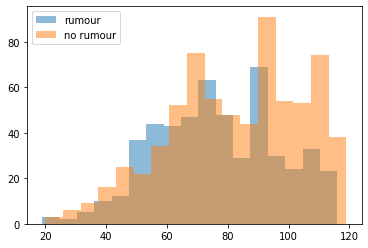

In [ ]:
count_words_and_plot(df, delete_stopwords=False)

Sin stopwords en el tweet


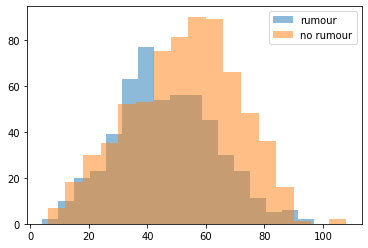

In [ ]:
count_words_and_plot(df, delete_stopwords=True)

Vemos que se encuentran ciertas diferencias en el tamaño de las oraciones escritas. Esto nos podria dar otra pista para comprender si es o no rumor, por lo que es una feature que se agrega. 

Se probo con el texto en diferentes etapas del pre procesamiento para ver donde se encuentran mayores diferencias. Las mismas parecerían estar antes de aplicar stopwords removal, por lo que se decidio aplicar el calculo de la longitud antes de remover las stopwords.

##Proxima feature a analizar: Name entity recognition

La idea es armar una feature por cada nombre de entidad reconocido. El valor de esa feature para cada dato es la cantidad de veces que aparece en el tweet.

In [ ]:
from pylab import rcParams

In [ ]:
df_test = df.copy()

In [ ]:
ner = spacy.load('en_core_web_sm')
ner_labels = ner.pipe_labels['ner']

def ner_counter(df):
  '''
  Creo las nuevas features (pueden ser varias) y les asigno los
  valores correspondientes segun el texto.
  '''

  out = df.copy()

  for label in ner_labels:
    out[label] = 0

  def set_ner_labels_count(row):
    '''
    Cuento los valores de cada ne encontrado y los pongo
    en el dataframe.
    '''
    sentece_ner = ner(row['text'])
    countered_labels = Counter([x.label_ for x in sentece_ner.ents])
    for key in countered_labels.keys():
      row[key] = countered_labels[key]
    return row

  out = out.apply(lambda x: set_ner_labels_count(x), axis=1)

  for label in ner_labels:
    if (out[label].sum() == 0):
      out.drop(label, axis=1, inplace=True)
  return out
df_ner = ner_counter(df_test)

In [ ]:
rcParams['figure.figsize'] = 6, 100

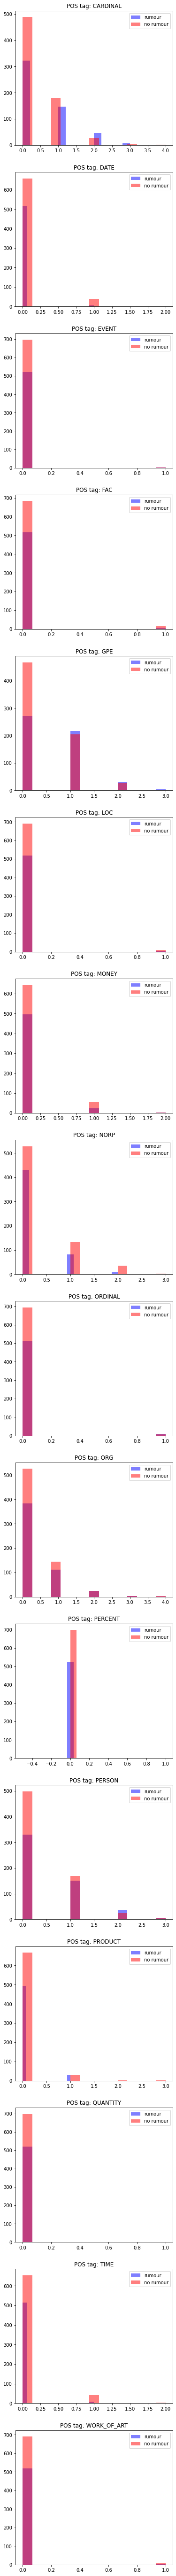

In [ ]:
from matplotlib import pyplot as plt

df_ner_labels = []
for l in ner_labels:
  if l in df_ner.columns.values:
    df_ner_labels.append(l)

#Si no muestra bien el tamaño de los graficos volver a correr esta celda.
fig, axs = plt.subplots(len(df_ner_labels))
if len(df_ner_labels) > 1:
  for i, l in enumerate(df_ner_labels):
    axs[i].hist(df_ner.loc[df_ner['rumour']=='yes', l], color='b', bins=15, alpha=0.5)
    axs[i].hist(df_ner.loc[df_ner['rumour']=='no', l], color='r', bins=15, alpha=0.5)
    axs[i].legend(['rumour', 'no rumour'])
    axs[i].set_title("POS tag: {}".format(l))
else:
  rcParams['figure.figsize'] = 6, 10
  plt.hist(df_pos.loc[df_pos['rumour']=='yes', df_ner_labels[0]], color='b', bins=15, alpha=0.5)
  plt.hist(df_pos.loc[df_pos['rumour']=='no', df_ner_labels[0]], color='r', bins=15, alpha=0.5)
  plt.legend(['rumour', 'no rumour'])
  print("POS label:", df_ner_labels[0])
    
plt.show()

Podemos ver que saber la cantidad de entidades nombradas en cada tweet no nos aportan información ya que hay igual cantidad de GPE y ORG en ambos. Este atributo por lo tanto no será agregado al pipeline.

## Ahora se intentará con etiquetado POS, contando la cantidad de etiquetas por cada tweet.

In [ ]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
pos_labels = list(tagdict.keys())
def pos_counter(df, is_list=False):
  '''
  Creo las nuevas features (pueden ser varias) y les asigno los
  valores correspondientes segun el texto.
  '''
  out = df.copy()
  tagdict = load('help/tagsets/upenn_tagset.pickle')
  pos_labels = list(tagdict.keys())

  pos_labels.append('#')  
  if is_list:
    out['text'].apply(lambda x: ' '.join(x))
    
  for label in pos_labels:
    out[label] = 0

  def set_pos_labels_count(row):
    '''
    Cuento los valores de cada pos encontrado y los pongo
    en el dataframe.
    '''
    def get_pos_tags(text):
      pos_tags = []
      for word in nltk.word_tokenize(text):
        pos = nltk.pos_tag([word])[0][1]
        pos_tags.append(pos)
      return pos_tags

    count_labels = Counter(get_pos_tags(row['text']))
    for key in count_labels.keys():
      row[key] = count_labels[key]
    return row

  out = out.apply(lambda x: set_pos_labels_count(x), axis=1)

  for label in pos_labels:
    if (out[label].sum() == len(out) * 0.1):
      out.drop(label, axis=1, inplace=True)
  return out

df_pos = (pos_counter(df))

In [ ]:
df_pos.iloc[1]

contributors                                                          None
truncated                                                            False
text                     BREAKING: Gunman takes hostages in cafe in Mar...
in_reply_to_status_id                                                 None
favorite_count                                                          12
                                               ...                        
SYM                                                                      0
CC                                                                       0
CD                                                                       0
POS                                                                      0
#                                                                        0
Name: 544268186292867072, Length: 71, dtype: object

In [ ]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
pos_labels = list(tagdict.keys())

pos_labels.append('#') 
labels_with_values = []
for l in pos_labels:
  if l in df_pos.columns.values:
    labels_with_values.append(l)
print(pos_labels)
print(labels_with_values)

['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS', '#']
['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS', '#']


In [ ]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
pos_labels = list(tagdict.keys())

pos_labels.append('#') 

#Buscamos las columnas con valores 0
for l in pos_labels:
  if l in df_pos.columns.values:
    if df_pos[l].sum() == 0:
      print(l)

LS
--
NNPS
RBS
FW
RP
PDT
SYM


In [ ]:
rcParams['figure.figsize'] = 6, 100

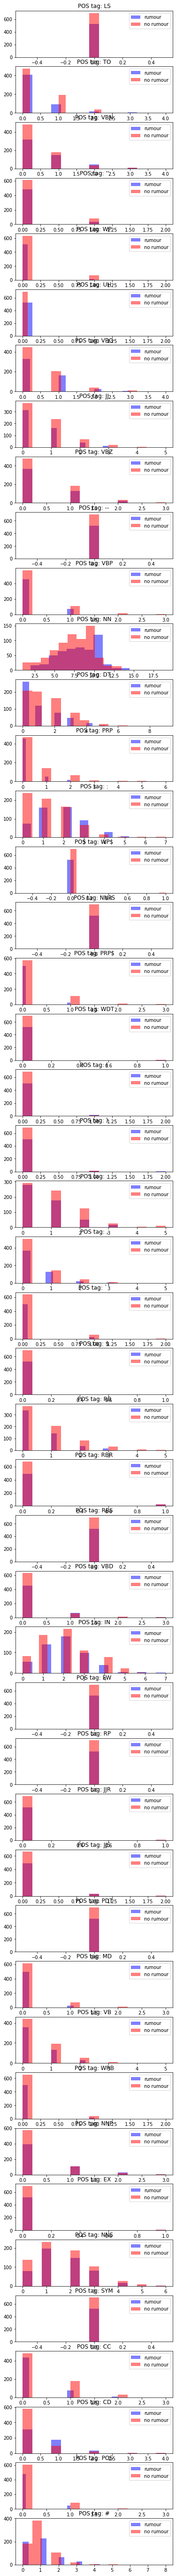

In [ ]:
from matplotlib import pyplot as plt

#Si no muestra bien el tamaño de los graficos volver a correr esta celda.
fig, axs = plt.subplots(len(labels_with_values))
if len(labels_with_values) > 1:
  for i, l in enumerate(labels_with_values):
    axs[i].hist(df_pos.loc[df_pos['rumour']=='yes', labels_with_values[i]], color='b', bins=15, alpha=0.5)
    axs[i].hist(df_pos.loc[df_pos['rumour']=='no', labels_with_values[i]], color='r', bins=15, alpha=0.5)
    axs[i].legend(['rumour', 'no rumour'])
    axs[i].set_title("POS tag: {}".format(l))
else:
  rcParams['figure.figsize'] = 6, 10
  plt.hist(df_pos.loc[df_pos['rumour']=='yes', labels_with_values[0]], color='b', bins=15, alpha=0.5)
  plt.hist(df_pos.loc[df_pos['rumour']=='no', labels_with_values[0]], color='r', bins=15, alpha=0.5)
  plt.legend(['rumour', 'no rumour'])
  print("POS label:", labels_with_values[0])
    
plt.show()

Podemos observar una ligera diferencia entre los rumores y los no rumores segun las POS tags calculados, (principalmente para NN por lo que obtendremos estos valores para utilizarlos en el pipeline y, en un futuro, ver si aportan información o no realizando feature selection.

Se probo modificar los valors del pipeline test = pre_processing_pipeline(df, lemmatize=False, delete_stopwords=True) para ver que diferencias ocurren. Tambien se probo de utilizar unicamente el dataframe completo. 

Se concluyo en que el pos tagger utiliza toda la informacion brindada en el texto, por lo que ejecutarlo antes de plantear todo el pre procesamiento beneficiara la informacion recopilada por el mismo.

Por lo explicado anteriormente se decidio aplicar el pos tag counter antes del preprocesamiento. 

### Representación de los tweets

*Definir la representación de los tweets a utilizar. Recordar que el objetivo final es entrenar un modelo de clasificación, con lo que la representación tiene que ser “amigable” con el posterior proceso de entrenamiento y test. Explicar brevemente la representación elegida*

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [ ]:
df_text = df_preprocessed['text'].copy()
df_text

id
544267656597995521    force hold isis flag lindt cafe sydneys martin...
544268186292867072                       gunman take cafe martin place 
544268637134393344    update isis flag display window caf siege sydn...
544268732046913536    hold siege take place sydney lindt chocolat ca...
544269221564137472    cafe martin place hold inside hand windows isi...
                                            ...                        
544521260840267776                      siege end storm lindt cafe run 
544521433473634304                                         news accord 
544521788777304064         watch gunfire erupt flee chocolate shop end 
544521880661950464                    authority confirm storm building 
544521948924248066      watch dramatic moment tactical team storm cafe 
Name: text, Length: 1221, dtype: object

Se opto por aplicar tfidf ya que es una tecnica simple y eficiente que nos permite obtener valores representativos del texto. Su principal desventaja es que no toma en cuenta el contexto de la oración para darle los pesos a cada palabra. Ademas, es la forma mas sencilla para utilizar los valores en modelos de ML simples, como arboles de clasificacion y svm. 

Se planteo la idea de usar algun otro valor, como alguna tecnica supervisada (mutual information por ej). Esto no se descartó, ya que el desarrollo de los modelos es a prueba y error puedo probar en un futuro aplicar diferentes métricas y ver con cuál se obtienen mejores resultados. Se planteó tfidf en un principio para dejar uno plasmado, aunque si no arroja buenos resultados se probará con otra técnica. 

También se planteó la idea de utilizar modelos de deep learning pero como aun no vimos el modulo de deep learning no le encontre la vuelta para que me convenza usar eso en vez de tfidf, me parecio demasiado overhead para los modelos simples ya que se guardan muchos mas valores por palabra.

In [ ]:
#Se busca limitar la cantidad de palabras que se agregaran como features
#ya que no tenemos una gran cantidad de datos como para que todos sea relevantes.
#Ademas aceleramos el feature selection que tendremos que hacer mas adelante.
#Reducimos a los textos que tienen un doc frequenciy de minimo 30, en donde asumimos
#que si una palabra aparece en menos de 30 documentos no nos será relevante.
tfidf = TfidfVectorizer(min_df=30)

tfidf_matrix = tfidf.fit_transform(df_text)
tfidf_matrix = tfidf_matrix.toarray()
vocab = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=vocab, index=df_text)

In [ ]:
tfidf_matrix.reset_index(drop=True, inplace=True)
tfidf_matrix

,amp,australia,australian,cafe,confirm,demand,escape,evacuate,flag,get,go,gunman,hold,hour,illridewithyou,inside,isis,islamic,know,lindt,live,man,martin,martinplace,medium,muslim,muslims,news,one,place,pm,pray,prayer,report,run,say,see,show,siege,situation,storm,take,thought,update,window
0,0.0,0.0,0.0,0.228793,0.000000,0.0,0.0,0.0,0.315761,0.0,0.0,0.000000,0.303479,0.0,0.0,0.000000,0.382523,0.0,0.0,0.333085,0.0,0.365903,0.364396,0.0,0.0,0.0,0.0,0.325952,0.0,0.354493,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.316342,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.413407,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.503834,0.0,0.0,0.0,0.0,0.000000,0.0,0.490142,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.48470,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.318532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.385879,0.0,0.0,0.000000,0.0,0.000000,0.367593,0.0,0.0,0.0,0.0,0.328812,0.0,0.357603,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.301618,0.0,0.000000,0.00000,0.0,0.349827,0.406399
3,0.0,0.0,0.0,0.217836,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.288946,0.0,0.0,0.000000,0.000000,0.0,0.0,0.317134,0.0,0.000000,0.346945,0.0,0.0,0.0,0.0,0.000000,0.0,0.675033,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.284676,0.0,0.000000,0.33377,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.238862,0.000000,0.0,0.0,0.0,0.329658,0.0,0.0,0.000000,0.316835,0.0,0.0,0.420594,0.399358,0.0,0.0,0.000000,0.0,0.000000,0.380433,0.0,0.0,0.0,0.0,0.340297,0.0,0.370094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,0.0,0.0,0.0,0.292702,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.426127,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.545124,0.0,0.0,0.0,0.382514,0.0,0.537833,0.00000,0.0,0.000000,0.000000
1217,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1218,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1219,0.0,0.0,0.0,0.000000,0.671257,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.741224,0.00000,0.0,0.000000,0.000000


In [ ]:
df_preprocessed.merge(tfidf_matrix, left_index=True, right_index=True)

,text,created_at,favorite_count,retweet_count,rumour,user_verified,user_followers,LS,TO,VBN,'',WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,...,demand,escape,evacuate,flag,get,go,gunman,hold,hour,illridewithyou,inside,isis,islamic,know,lindt,live,man,martin,martinplace,medium,muslim,muslims,news,one,place,pm,pray,prayer,report,run,say,see,show,siege,situation,storm,take,thought,update,window


In [ ]:
tfidf = TfidfVectorizer()

def apply_tfidf(df, tfidf=None, min_df=30):
  out = df.copy()

  start = time.time()
  train = False
  if tfidf is None:
    train = True
    tfidf = TfidfVectorizer(min_df=min_df)
    tfidf_matrix = tfidf.fit_transform(out['text'])
    tfidf_matrix = tfidf_matrix.toarray()
  else:
    tfidf_matrix = tfidf.transform(out['text']) 
    tfidf_matrix = tfidf_matrix.toarray()

  vocab = tfidf.get_feature_names()
  tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=vocab)
  end = time.time()
  print("Time transforming to tf-idf: ", end - start)

  if train:
    return out.merge(tfidf_matrix, left_index=True, right_index=True), tfidf
  else:
    return out.merge(tfidf_matrix, left_index=True, right_index=True)

In [ ]:
apply_tfidf(df_preprocessed)

Time transforming to tf-idf:  0.017041444778442383


(Empty DataFrame
 Columns: [text, created_at, favorite_count, retweet_count, rumour, user_verified, user_followers, LS, TO, VBN, '', WP, UH, VBG, JJ, VBZ, --, VBP, NN, DT, PRP, :, WP$, NNPS, PRP$, WDT, (, ), ., ,, ``, $, RB, RBR, RBS, VBD, IN, FW, RP, JJR, JJS, PDT, MD, VB, WRB, NNP, EX, NNS, SYM, CC, CD, POS, #, word_count, sentiment, amp, australia, australian, cafe, confirm, demand, escape, evacuate, flag, get, go, gunman, hold, hour, illridewithyou, inside, isis, islamic, know, lindt, live, man, martin, martinplace, medium, muslim, muslims, news, one, place, pm, pray, prayer, report, run, say, see, show, siege, situation, storm, take, thought, update, window]
 Index: []
 
 [0 rows x 100 columns],
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=30, ngram_range=(1, 1), norm='l2', preprocessor=

## Preparamos las columnas categoricas para que sean numericas

In [ ]:
def prepare_rumour_column(rumour):
  if rumour == 'yes':
    return 1
  else:
    return 0

#One hot encoding de esta variable
def prepare_user_verified_column(row):
  if row['user_verified'] == True:
    row['user_verified_true'] = 1
  else:
    row['user_verified_false'] = 1
  return row

def prepare_categorical_data(df):
  out = df.copy()
  start = time.time()
  out['rumour'] = out['rumour'].apply(lambda x: prepare_rumour_column(x))
  out['user_verified_true'] = 0
  out['user_verified_false'] = 0
  out = out.apply(lambda x: prepare_user_verified_column(x), axis=1)
  out.drop('user_verified', axis=1, inplace=True)
  end = time.time()
  print("Time transforming categorical data: ", end - start)

  return out

## Normalizamos las celdas con valores más elevados

In [ ]:
def normalize_columns(df, normalize_sums=None, columns=['favorite_count', 'retweet_count', 'user_followers']):
  out = df.copy()

  train = False
  if normalize_sums is None:
    train = True
    normalize_sums = {}    

  start = time.time()
  for c in columns:
    #Para futuros inputs tengo que guardar este valor, es solo para train el calculo
    if train:
      normalize_sums[c] = out[c].max()
    out[c] = out[c] / normalize_sums[c]

  end = time.time()
  print("Time normalizing data: ", end - start)
  if train:
    return out, normalize_sums
  else:
    return out

# Ahora todo el pipeline junto

### NOTA: todo lo que continua es solo una funcion que agrupa todo lo realizado anteriormente, la cual te permite seleccionar si son datos de entrenamiento o no y te devuelve los valores correspondientes.

### La funcion se encuentra al final de la siguiente celda y se muestran casos de prueba para train y test a continuacion.

In [ ]:
!pip install unidecode
!pip install contractions
!pip install spacy

import re
import contractions
import nltk
import spacy
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from unidecode import unidecode
from IPython.display import clear_output
from collections import Counter
import string
from nltk.data import load
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.extend(["co","http","sydneysiege","sydney","hostages","police","hostage","people", 'breaking'])
sid = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm")
clear_output()

def remove_websites(text, startWith='http'):
  '''
  Se remueven los sitios web de los tweets (iniciando con http y www).
  '''
  try:
    out = text
    while (True):
      http_index = out.index(startWith)
      try:
        end_http_index = out[http_index:].index(" ") + http_index
      except:
        end_http_index = len(out)
      out = out[:http_index] + out[end_http_index:]
  except:
    return out

def remove_special_characters(text):
  '''
  Se mantienen solo las letras en el texto.
  '''
  pattern = r'[^a-z\s]'
  text = re.sub(pattern, '', text)
  return text

def remove_stopwords(text):
  '''
  Se eliminan los stopwords (nltk+agregados)
  '''
  text_no_stopwords = [w for w in text.split() if not w in nltk_stopwords]
  return ' '.join(text_no_stopwords)

def remove_accent_mark(text, words=None):
  ''' 
  Se eliminan las tildes de las palabras elegidas
  '''
  out = []
  if words is None:
    return
  for w in text.split():
    if w in words:
      out.append(unidecode(w))
    else:
      out.append(w)
  return ' '.join(out)

#Feature agregada
def sentiment_value(text, is_list=False):
  ''' 
  Usamos NLTK vader ya que se dice que es mejor para texto
  de redes sociales. Obtenemos solamente el compound.
  '''
  if is_list:
    text = ' '.join(text)
  polarity_score = sid.polarity_scores(text)
  return polarity_score['compound']

#Feature agregada
def pos_counter(df, is_list=True):
  '''
  Creo las nuevas features (pueden ser varias) y les asigno los
  valores correspondientes segun el texto.
  '''
  out = df.copy()

  tagdict = load('help/tagsets/upenn_tagset.pickle')
  pos_labels = list(tagdict.keys())
  pos_labels.append('#')  

  if is_list:
    out['text'].apply(lambda x: ' '.join(x))
    
  for label in pos_labels:
    out[label] = 0

  def set_pos_labels_count(row):
    '''
    Cuento los valores de cada pos encontrado y los pongo
    en el dataframe.
    '''
    def get_pos_tags(text):
      pos_tags = []
      for word in nltk.word_tokenize(text):
        pos = nltk.pos_tag([word])[0][1]
        pos_tags.append(pos)
      return pos_tags

    count_labels = Counter(get_pos_tags(row['text']))
    for key in count_labels.keys():
      row[key] = count_labels[key]
    return row

  out = out.apply(lambda x: set_pos_labels_count(x), axis=1)

  return out

#Feature modificada, anteriormente era stemming
def lemmatize_text(text, is_list=False):
  '''
  Internamente spaCy usa etiquetado POS. Otra opción 
  es utilizar NLTK y hacer a mano el etiquetado POS (con 
  alguna libreria).

  Anteriormente se realizo stemming pero con lo que se aprendió
  de lemmatización se optó por esta opción.
  '''
  if is_list:
    text = ' '.join(text)
  
  doc = nlp(text)
  lemmatized = ''
  for word in doc:
    if not word.lemma_.startswith('-') :
        lemmatized += word.lemma_ + ' '
  
  return lemmatized

def pre_processing_pipeline(df, lemmatize=True, delete_stopwords=True):
  out = df.copy()

  start = time.time()
  out = out[['text', 'user', 'created_at', 'favorite_count', 'retweet_count', 'rumour']]
  
  #Nos quedamos solo con el verified del usuario y con la cantidad de seguidores que tenga la acc.
  out['user_verified'] = out['user'].apply(lambda x: x['verified'])
  out['user_followers'] = out['user'].apply(lambda x: x['followers_count'])
  out.drop('user', axis=1, inplace=True)
  
  #Del created_at nos quedamos unicamente con la hora en el que se realizó el tweet
  out['created_at'] = out['created_at'].apply(lambda x: datetime.strptime(x[:-11], '%a %b %d %H:%M:%S').time().hour)
  end = time.time()
  print("Time selecting features: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_websites(x))
  out['text'] = out['text'].apply(lambda x: remove_websites(x, startWith='www'))
  end = time.time()
  print("Time removing websites: ", end - start)
  
  #Feature agregada
  start = time.time()
  out = pos_counter(out)
  end = time.time()
  print("Time counting POS labels: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: x.lower())
  end = time.time()
  print("Time setting to lowercase: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
  out['text'] = out['text'].apply(lambda x: ' '.join(x))
  end = time.time()
  print("Time fixing contractions: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_special_characters(x))
  end = time.time()
  print("Time removing special characters: ", end - start)

  #Eliminamos las tildes en café y cafés.
  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_accent_mark(x, ['café', 'cafés']))
  end = time.time()
  print("Time removing accent marks in café and cafés: ", end - start)

  #Se elimino el spell check ya que demora mucho tiempo.

  #Feature agregada
  start = time.time()
  out['word_count'] = out['text'].apply(lambda x: len(x))
  end = time.time()
  print("Time counting words: ", end - start)

  if delete_stopwords:
    start = time.time()
    out['text'] = out['text'].apply(lambda x: remove_stopwords(x))
    end = time.time()
    print("Time removing stopwords: ", end - start)

  #Feature agregada
  start = time.time()
  out['sentiment'] = out['text'].apply(lambda x: sentiment_value(x, is_list=True))
  end = time.time()
  print("Time analizing sentiment: ", end - start)

  #Feature modificada, anteriormente era stemming
  if lemmatize:
    start = time.time()
    out['text'] = out['text'].apply(lambda x: lemmatize_text(x))
    end = time.time()
    print("Time lemmatizing: ", end - start)

  return out

def apply_tfidf(df, tfidf=None, min_df=30):
  out = df.copy()
  start = time.time()
  train = False
  if tfidf is None:
    train = True
    tfidf = TfidfVectorizer(min_df=min_df)
    tfidf_matrix = tfidf.fit_transform(out['text'])
    tfidf_matrix = tfidf_matrix.toarray()
  else:
    tfidf_matrix = tfidf.transform(out['text']) 
    tfidf_matrix = tfidf_matrix.toarray()
  vocab = tfidf.get_feature_names()
  tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=vocab)
  end = time.time()
  print("Time transforming to tf-idf: ", end - start)

  if train:
    return out.merge(tfidf_matrix, left_index=True, right_index=True), tfidf
  else:
    return out.merge(tfidf_matrix, left_index=True, right_index=True)

def prepare_rumour_column(rumour):
  if rumour == 'yes':
    return 1
  else:
    return 0

#One hot encoding de esta variable
def prepare_user_verified_column(row):
  if row['user_verified'] == True:
    row['user_verified_true'] = 1
  else:
    row['user_verified_false'] = 1
  return row

def prepare_categorical_data(df):
  out = df.copy()
  start = time.time()
  out['rumour'] = out['rumour'].apply(lambda x: prepare_rumour_column(x))
  out['user_verified_true'] = 0
  out['user_verified_false'] = 0
  out = out.apply(lambda x: prepare_user_verified_column(x), axis=1)
  out.drop('user_verified', axis=1, inplace=True)
  end = time.time()
  print("Time transforming categorical data: ", end - start)

  return out

def normalize_columns(df, normalize_sums=None, columns=['favorite_count', 'retweet_count', 'user_followers']):
  out = df.copy()

  train = False
  if normalize_sums is None:
    train = True
    normalize_sums = {}    

  start = time.time()
  for c in columns:
    #Para futuros inputs tengo que guardar este valor, es solo para train el calculo
    if train:
      normalize_sums[c] = out[c].max()
    out[c] = out[c] / normalize_sums[c]

  end = time.time()
  print("Time normalizing data: ", end - start)
  if train:
    return out, normalize_sums
  else:
    return out
   
#prero func
def prepare_input(df, train=True, tfidf=None, values_to_normalize=None):
  '''
  En caso de ser entrenable hay que pasarle los modelos de tfidf y las sumas
  ya realizadas.
  En caso de que se desee entrenar se retornan el modelo de tfidf y 
  un arreglo con los valores para normalizar. Estos se deben guardar para
  cuando se desee aplicar el preprocesamiento a los datos de val/test.
  '''
  if not train and tfidf is None and values_to_normalize is None:
    print("Se necesita el modelo tfidf y el vector de sumas para normalizar :)")
    return 
  start = time.time()
  out = df.copy()
  out = out.reset_index(drop=True)
  
  out = pre_processing_pipeline(out)
  if train:
    out, tfidf = apply_tfidf(out)
  else:
    out = apply_tfidf(out, tfidf)
  out = prepare_categorical_data(out)
  if train:
    out, values_to_normalize = normalize_columns(out)
  else:
    out = normalize_columns(out, values_to_normalize)
  out.drop('text', axis=1, inplace=True)
  end = time.time()
  print("Total time pre processing: ", end - start)

  if train:
    return out, tfidf, values_to_normalize
  else:
    return out

In [ ]:
data, tfidf_trained, values_to_norm_trained = prepare_input(df, train=True)

Time selecting features:  0.026493072509765625
Time removing websites:  0.0043179988861083984
Time counting POS labels:  3.337688684463501
Time setting to lowercase:  0.0014934539794921875
Time fixing contractions:  0.05288100242614746
Time removing special characters:  0.0041577816009521484
Time removing accent marks in café and cafés:  0.004776716232299805
Time counting words:  0.0019383430480957031
Time removing stopwords:  0.035645246505737305
Time analizing sentiment:  0.023176193237304688
Time lemmatizing:  10.779835939407349
Time transforming to tf-idf:  0.01584625244140625
Time transforming categorical data:  0.23427391052246094
Time normalizing data:  0.002458810806274414
Total time pre processing:  14.542391777038574


In [ ]:
data

,created_at,favorite_count,retweet_count,rumour,user_followers,LS,TO,VBN,'',WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,...,evacuate,flag,get,go,gunman,hold,hour,illridewithyou,inside,isis,islamic,know,lindt,live,man,martin,martinplace,medium,muslim,muslims,news,one,place,pm,pray,prayer,report,run,say,see,show,siege,situation,storm,take,thought,update,window,user_verified_true,user_verified_false
0,23,0.000361,0.004471,1,0.000073,0,1,1,0,0,0,1,0,0,0,1,10,3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,...,0.0,0.315761,0.0,0.0,0.000000,0.303479,0.0,0.0,0.000000,0.382523,0.0,0.0,0.333085,0.0,0.365903,0.364396,0.0,0.0,0.0,0.0,0.325952,0.0,0.354493,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1,23,0.000080,0.001497,1,0.000092,0,0,0,0,0,0,0,0,1,0,0,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.413407,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.503834,0.0,0.0,0.0,0.0,0.000000,0.0,0.490142,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.48470,0.0,0.000000,0.000000,1,0
2,23,0.000260,0.002030,1,0.001175,0,0,0,0,0,0,1,0,1,0,0,12,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,...,0.0,0.318532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.385879,0.0,0.0,0.000000,0.0,0.000000,0.367593,0.0,0.0,0.0,0.0,0.328812,0.0,0.357603,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.301618,0.0,0.000000,0.00000,0.0,0.349827,0.406399,1,0
3,23,0.000060,0.001085,1,0.006593,0,0,0,0,0,0,2,0,1,0,1,10,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.288946,0.0,0.0,0.000000,0.000000,0.0,0.0,0.317134,0.0,0.000000,0.346945,0.0,0.0,0.0,0.0,0.000000,0.0,0.675033,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.284676,0.0,0.000000,0.33377,0.0,0.000000,0.000000,1,0
4,23,0.000561,0.006682,1,0.000073,0,0,0,0,0,0,1,0,1,0,0,9,2,0,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,...,0.0,0.329658,0.0,0.0,0.000000,0.316835,0.0,0.0,0.420594,0.399358,0.0,0.0,0.000000,0.0,0.000000,0.380433,0.0,0.0,0.0,0.0,0.340297,0.0,0.370094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,15,0.000120,0.001005,0,0.130875,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.426127,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.545124,0.0,0.0,0.0,0.382514,0.0,0.537833,0.00000,0.0,0.000000,0.000000,1,0
1217,15,0.002103,0.004913,0,0.202441,0,1,0,0,0,0,2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1218,15,0.000608,0.001819,0,0.085378,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1219,15,0.000234,0.001176,0,0.001578,0,0,1,0,0,0,0,0,1,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.741224,0.00000,0.0,0.000000,0.000000,1,0


In [ ]:
data = prepare_input(df, train=False, tfidf=tfidf_trained, values_to_normalize=values_to_norm_trained)

Time selecting features:  0.025410890579223633
Time removing websites:  0.004647493362426758
Time counting POS labels:  3.293600082397461
Time setting to lowercase:  0.0016465187072753906
Time fixing contractions:  0.05415153503417969
Time removing special characters:  0.004248142242431641
Time removing accent marks in café and cafés:  0.004839658737182617
Time counting words:  0.0017361640930175781
Time removing stopwords:  0.03484511375427246
Time analizing sentiment:  0.02214503288269043
Time lemmatizing:  10.159387350082397
Time transforming to tf-idf:  0.011123180389404297
Time transforming categorical data:  0.25870752334594727
Time normalizing data:  0.0028476715087890625
Total time pre processing:  13.89601445198059


In [ ]:
data

,created_at,favorite_count,retweet_count,rumour,user_followers,LS,TO,VBN,'',WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,...,evacuate,flag,get,go,gunman,hold,hour,illridewithyou,inside,isis,islamic,know,lindt,live,man,martin,martinplace,medium,muslim,muslims,news,one,place,pm,pray,prayer,report,run,say,see,show,siege,situation,storm,take,thought,update,window,user_verified_true,user_verified_false
0,23,0.000361,0.004471,1,0.000073,0,1,1,0,0,0,1,0,0,0,1,10,3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,...,0.0,0.315761,0.0,0.0,0.000000,0.303479,0.0,0.0,0.000000,0.382523,0.0,0.0,0.333085,0.0,0.365903,0.364396,0.0,0.0,0.0,0.0,0.325952,0.0,0.354493,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1,23,0.000080,0.001497,1,0.000092,0,0,0,0,0,0,0,0,1,0,0,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.413407,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.503834,0.0,0.0,0.0,0.0,0.000000,0.0,0.490142,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.48470,0.0,0.000000,0.000000,1,0
2,23,0.000260,0.002030,1,0.001175,0,0,0,0,0,0,1,0,1,0,0,12,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,...,0.0,0.318532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.385879,0.0,0.0,0.000000,0.0,0.000000,0.367593,0.0,0.0,0.0,0.0,0.328812,0.0,0.357603,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.301618,0.0,0.000000,0.00000,0.0,0.349827,0.406399,1,0
3,23,0.000060,0.001085,1,0.006593,0,0,0,0,0,0,2,0,1,0,1,10,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.288946,0.0,0.0,0.000000,0.000000,0.0,0.0,0.317134,0.0,0.000000,0.346945,0.0,0.0,0.0,0.0,0.000000,0.0,0.675033,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.284676,0.0,0.000000,0.33377,0.0,0.000000,0.000000,1,0
4,23,0.000561,0.006682,1,0.000073,0,0,0,0,0,0,1,0,1,0,0,9,2,0,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,...,0.0,0.329658,0.0,0.0,0.000000,0.316835,0.0,0.0,0.420594,0.399358,0.0,0.0,0.000000,0.0,0.000000,0.380433,0.0,0.0,0.0,0.0,0.340297,0.0,0.370094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,15,0.000120,0.001005,0,0.130875,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.426127,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.545124,0.0,0.0,0.0,0.382514,0.0,0.537833,0.00000,0.0,0.000000,0.000000,1,0
1217,15,0.002103,0.004913,0,0.202441,0,1,0,0,0,0,2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1218,15,0.000608,0.001819,0,0.085378,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1219,15,0.000234,0.001176,0,0.001578,0,0,1,0,0,0,0,0,1,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.741224,0.00000,0.0,0.000000,0.000000,1,0


# Test con 1000 valores de train y el resto de test, para observar como se comporta.

In [ ]:
train, tfidf_trained, values_to_norm_trained = prepare_input(df.iloc[:1000], train=True)

Time selecting features:  0.021522045135498047
Time removing websites:  0.0038971900939941406
Time counting POS labels:  2.6746373176574707
Time setting to lowercase:  0.0013492107391357422
Time fixing contractions:  0.04364657402038574
Time removing special characters:  0.0034759044647216797
Time removing accent marks in café and cafés:  0.0059468746185302734
Time counting words:  0.00214385986328125
Time removing stopwords:  0.031647443771362305
Time analizing sentiment:  0.018387556076049805
Time lemmatizing:  8.35563325881958
Time transforming to tf-idf:  0.013485431671142578
Time transforming categorical data:  0.18378114700317383
Time normalizing data:  0.003477334976196289
Total time pre processing:  11.382712125778198


In [ ]:
test = prepare_input(df.iloc[1000:], False, tfidf_trained, values_to_norm_trained)

Time selecting features:  0.010980844497680664
Time removing websites:  0.0018911361694335938
Time counting POS labels:  0.6262569427490234
Time setting to lowercase:  0.0012521743774414062
Time fixing contractions:  0.011001110076904297
Time removing special characters:  0.0012552738189697266
Time removing accent marks in café and cafés:  0.0013325214385986328
Time counting words:  0.0011591911315917969
Time removing stopwords:  0.006456136703491211
Time analizing sentiment:  0.004710674285888672
Time lemmatizing:  1.9630308151245117
Time transforming to tf-idf:  0.003828287124633789
Time transforming categorical data:  0.06107473373413086
Time normalizing data:  0.001665353775024414
Total time pre processing:  2.713224172592163


In [ ]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Tienen las mismas columnas?", list(train.columns.values) == list(test.columns.values))

Train shape: (1000, 91)
Test shape: (221, 91)
Tienen las mismas columnas? True
